In [1]:
%%capture
# Load the quadrotor simulator from a previous notebook
%run quadsim.ipynb

In [2]:
from IPython.core.display import HTML
HTML('<style>.impl-inner{background-color:#e4ffe6} .impl-outer{background-color:#e4ebff} .text_cell_render p { text-align: justify; text-justify: inter-word;}</style>')

# Image-Based Visual Servoing of a Quadrotor

Our goal is to use visual information to steer the quadrotor into a desired configuration. The implementation found in this notebook is based largely off of the work by Zheng et al. \[1].

## II. Quadrotor Model

The dynamical quadrotor model used throughout this notebook is the essentially the same rigid-body model found in the [quadrotor_model](quadrotor_mode.ipynb) notebook. Specifically, this model expressed velocity $V$ in the body frame. The equations of motion (EOM) are rewritten here for convenience
$$
\begin{align}
\dot{r} &= RV \\
\dot{R} &= R\omega^\wedge \\
m\dot{V} &= -m\omega\times V + F \\
J\dot{\omega} &= -\omega\times J\omega + \tau \\
F &= -u_1 E_3 + mgR^\top e_3,
\end{align}
$$
where $r,V\in\mathbb{R}^3$ are the inertial position and body velocity of the vehicle, $R\in\text{SO}(3)$ is the attitude of the body w.r.t the inertial frame, $\omega\in\mathbb{R}^3$ is the angular velocity of the body w.r.t the inertial frame, expressed in the body frame. The mass of the vehicle is given by $m\in\mathbb{R}$, the inertia matrix by $J\in\mathbb{R}^{3\times 3}$, and the acceleration due to gravity by $g\in\mathbb{R}$. The vectors $E_3 = e_3 = (0\ 0\ 1)^\top$ are expressed in the body frame and the inertial frame, respectively. Finally, $\cdot^\wedge$ is the *hat-map*, defined by
$$
\begin{align}
\cdot^\wedge : \mathbb{R}^3 &\to \mathfrak{so}(3) \\
\omega^\wedge &\mapsto \begin{bmatrix} 0&-r&q\\r&0&-p\\-q&p&0 \end{bmatrix}.
\end{align}
$$

## IIII. Image Features and Their Dynamics

### Coordinate Frames

In order to design a controller for the quadrotor, we would like to express image features in the *virtual camera* frame. This frame is also known as the local-level or vehicle-1 frame. Therefore, we require the rotation $R_c^b$ from the camera frame, $\mathcal{F}_c$ to the body frame $\mathcal{F}_b$. Note that in the case where there is no gimbal, this rotation matrix is known from the mechanical design of the quadrotor-camera system and does not change. In this notebook, our camera is mounted at a 45-degree angle below the horizontal. Accounting for the coordinate frame of a camera (see [sensors](sensors.ipynb)), the desired rotation matrix is
$$
\begin{align}
R_c^b := \left[R_x(\pi/4) R_y(0) R_z(\pi/2)\right]^\top.
\end{align}
$$

The rotation from the body frame $\mathcal{F}_b$ to the vehicle-1 frame $\mathcal{F}_{v1}$ is given by
$$
\begin{align}
R_b^{v1}(\phi,\theta) &= R_{v2}^{v1}(\theta) R_b^{v2}(\phi) \\
&=
\begin{bmatrix}
\cos\theta & 0 & -\sin\theta \\
0 & 1 & 0 \\
\sin\theta & 0 & \cos\theta
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos\phi & \sin\phi \\
0 & -\sin\phi & \cos\phi
\end{bmatrix}.
\end{align}
$$

The relevant Python code is given below.

In [3]:
Rb2c = rot3d(45,0,90) # camera is mounted at 45-degree down

def Rot_v1_to_b(phi, theta, *args): return Rot_v2_to_b(phi).dot(Rot_v1_to_v2(theta))
def Rot_b_to_v1(phi, theta, *args): return Rot_v1_to_b(phi, theta).T

### Camera Measurement Model

Recall that a camera is essentially a bearing-only sensor. Given the pixel coordinates $(u, v)^\top$ of a 3D object projected onto the plane, the [camera geometry](sensors.ipynb#Camera) can be used to find a unit line-of-sight vector.

The camera matrix $K$ encodes the intrinsic parameters of a camera/lens system and can be found via camera calibration. It is used to project points on the normalized image plane onto the pixel plane. It has the form
$$
K = \begin{bmatrix} f & 0 & c_x \\ 0 & f & c_y \\ 0 & 0 & 1 \end{bmatrix}
$$
where $f$ is the focal length in pixels, and $c_x, c_y$ are the pixel offsets to the principal point (i.e., the center of the image).

Unit line-of-sight (LOS) vectors can be constructed from points on the normalized image plane via $\hat\ell = \frac{p^{im}}{\left|p^{im}\right|}$. To convert pixel coordinates to normalized image coordinates, simply pre-multiply by the inverse of the camera matrix $K$.

The following Python code converts pixels to unit LOS vectors in the vehicle-1 frame.

In [4]:
def target_los(x_cam, state, camera):
    # rotation from body to camera
    Rb2c = camera.R
    
    # make homogeneous
    hx_cam = np.vstack((x_cam,1))
    
    # project to normalized image plane, with unit focal length
    hx_cam_nip = np.linalg.inv(camera.K).dot(hx_cam)
    
    # rotate to vehicle-1 frame
    hx_veh1 = Rot_b_to_v1(*state[6:9,0]).dot(Rb2c.T.dot( hx_cam_nip ))
       
    # normalize
    hx_veh1 = hx_veh1 / np.linalg.norm(hx_veh1[:3,:])
    
    return hx_veh1

## IV. IBVS Controller

Here we design an image-based visual servoing controller based on the nonlinear design tools backstepping and Lyapunov analysis.

In [47]:
class IBVS(Controller):
    """Image-based Visual Servoing Controller
    """
    def __init__(self, camera):
        self.name = "IBVS"
        
        # camera object
        self.camera = camera
        
        # estimates of the physical properties of the quadrotor
        self.g = 9.8
        self.mass = 4
        self.I = np.diag(np.array([0.1, 0.1, 0.1]))
        
        self.g = 9.81
        self.mass = 3.81
        self.I = np.diag(np.array([0.060224, 0.122198, 0.132166]))
        
        # Attitude (inner loop) PID controllers
        self.pid_roll = SimplePID(7.63, None, 0.95, -np.pi/6, np.pi/6)
        self.pid_pitch = SimplePID(7.63, None, 1.55, -np.pi/6, np.pi/6)
        self.pid_yaw_rate = SimplePID(2.86, None, None, -np.pi, np.pi)
        
    def innerPID(self, cmds, state, Ts):
        
        # flatten the inputs for easy access
        s = state.flatten()
        
        U1 = cmds[0]
        phid = cmds[1]
        thetad = cmds[2]
        
        # ?
        psidotd = 0
        
        # Force (f) and moments (tau_*)
        tph = self.pid_roll.run(phid-s[6], Ts)
        tth = self.pid_pitch.run(thetad-s[7], Ts)
        tps = self.pid_yaw_rate.run(psidotd-s[11], Ts)
        
        return np.array([U1, tph, tth, tps])
    
    def outer(self, x_cam, state, Ts):
        # calculate unit LOS vectors to targets
        hx_veh1 = target_los(x_cam, state, self.camera)
#         print(hx_veh1.T)
              
        # calculate the depth value when the camera is at the desired pose
        h = -state[2,0]
        zdes = h/np.cos(np.pi/4)
    
        # LOS vector is the feature q
        q = hx_veh1
        
        # image error
        q1 = q - np.array([[0.707,0,0.707]]).T
        
#         print("q1: ", q1.T)
        
        # other error
        c1 = 10
        q2 = q1 - 1.0/c1 * state[3:6]
        
        k3 = 1
        f = k3*q2
        
        f = f.flatten()
        
        # convert
        phi = -f[1] / (f[2] - self.g)
        theta = f[0] / (f[2] - self.g)
        U1 = -self.mass*(f[2] - self.g)
        
        return np.array([U1, phi, theta])
    

    def update(self, commanded, state, pkt, Ts):
        
        if 'Camera' in pkt:
            x_cam = pkt['Camera']

        else:
            x_cam = np.array([[400,300]]).T
#             x_cam = np.array([[0,0]]).T
        
        #
        # Outer Loop
        #
        
        cmds = self.outer(x_cam, state, Ts)
        
#         print(cmds)
        
        #
        # Inner Loop
        #
        
        cmds[1] = 0
        cmds[2] = 0
        
        u = self.innerPID(cmds, state, Ts)
        
#         print(u.T)
        
        # update the commanded states
        commanded[6] = cmds[1] # phi
        commanded[7] = cmds[2] # theta
        
        # actuator commands
        return u, commanded

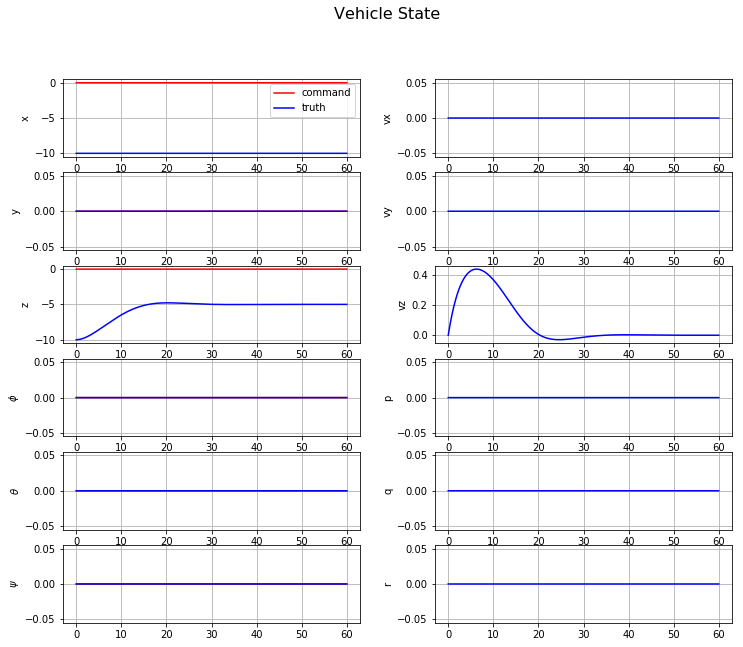

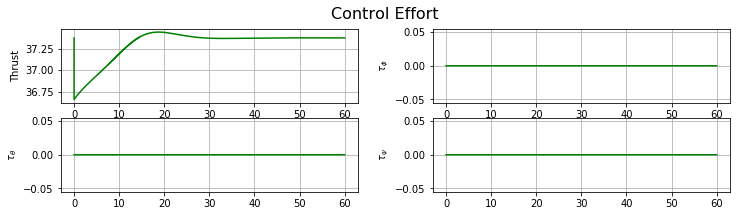

Quadrotor state after 6000 iters:
	r:     [[-10.000  0.000 -4.998]].T
	Phi:   [[ 0.000  0.000  0.000]].T
	v:     [[ 0.000  0.000 -0.000]].T
	omega: [[ 0.000  0.000  0.000]].T



In [51]:
# target dynamics
def target_tick(capture, n, Ts):
    
    # ellipse
    f = 0.05 # Hz
    x = 10*np.sin(2*np.pi*f*n*Ts)
    y = 5*np.cos(2*np.pi*f*n*Ts)
    
    x = y = 0
    x = -5
    
#     f = 0.017
#     x = 0*np.sin(2*np.pi*f*n*Ts)
#     y = 2.5*np.cos(2*np.pi*f*n*Ts)
    
    
    return np.array([[x,y,0]]).T

# Instantiate a quadrotor model with the given initial conditions
quad = Quadrotor(r=np.array([[-10],[0],[-10]]),
                 v=np.array([[0],[0],[0]]),
               Phi=np.array([[0],[0],[0]]))

# Create sensors
camera = Camera(tick=target_tick)
camera.set_transformation(R=Rb2c)

# Register sensors with the sensor manager
sens = SensorManager()
sens.register(camera)

# Instantiate an IBVS controller
ctrl = IBVS(camera)

# Instantiate an estimator that gives truth with body velocities
estm = Estimator(body=True)

# Setup a setpoint commander
cmdr = Commander(default=True)

# Run the simulation
sim = Simulator(quad, ctrl, estm, cmdr, sens)
sim.run(60, Ts=0.01)
sim.plot()

print(quad)

## Velocity Observer

In our IBVS controller we will need to use the velocity of the virtual camera frame $\mathcal{F}^{VC}$. Here we design an observer to estimate the velocity of the virtual camera frame.

In [7]:
%%capture
_NO_SIM = True
%run sliding_mode_control.ipynb
_NO_SIM = False

In [8]:
class VelocityObserver(Estimator):
    def __init__(self, camera, body=True):
        super().__init__(body=body)
        self.name = "Virtual Camera Velocity Observer"
        
        self.camera = camera
        
        self.g = 9.81
        self.m = 3.81
        
        # observer variables
        self.v0 = np.zeros((3,1))
        self.vhat = np.zeros((3,1))
        self.q1hat = np.zeros((3,1))
    
    def update(self, quad, u, Ts):
        
        truth = self.get_truth(quad)
        state = np.copy(truth)
        
        x_cam = self.camera.meas
        
        # calculate unit LOS vectors to targets
        hx_veh1 = target_los(x_cam, state, self.camera)

#         print(x_cam.T, hx_veh1.T)
        
        ########
        ########
        ########
        
        # calculate the depth value when the camera is at the desired pose
        h = -truth[2,0]
        zdes = h/np.cos(np.pi/4)
    
        # LOS vector is the feature q
        q = hx_veh1
        
        # image error
        q1 = q - np.array([[0,0,1]]).T

        # gains
        k1 = 5
        k2 = 0.5
        
        # estimation error equation (19)
        q1err = q1 - self.q1hat
        
        # equation (23)
        Q = state[11, 0] # yaw dot
        f = lambda q1hat: -1/zdes*self.vhat - np.array([[0,-Q,0],[Q,0,0],[0,0,0]]).dot(q1) + k1*q1err
        self.q1hat = rk4(f, self.q1hat, Ts)
        
        # equation (22)
        Rb_2_v1 = rot3(state[6,0],state[7,0],0).T
        force = -Rb_2_v1.dot(np.array([[0,0,u[0]]]).T)/self.m + np.array([[0,0,self.g]]).T
        f = lambda v0: -np.array([[0,-Q,0],[Q,0,0],[0,0,0]]).dot(self.vhat) + force - k2*k1*q1err - 1/zdes*q1err
        self.v0 = rk4(f, self.v0, Ts)
        
        # equation (21)
        self.vhat = self.v0 - k2*q1err
        
        state[3:6] = self.vhat
        
        return state, truth

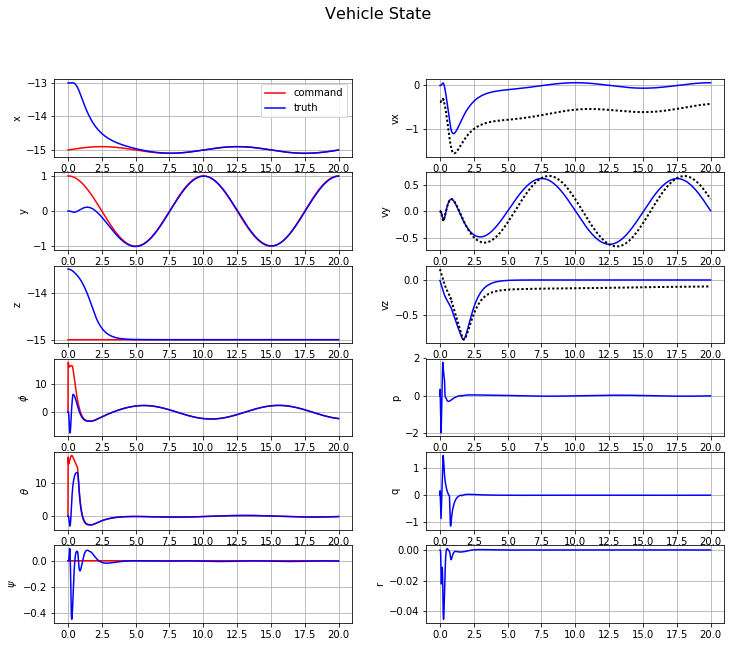

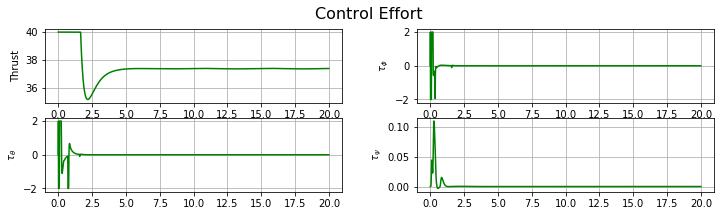

In [9]:
# Instantiate a quadrotor model with the given initial conditions
quad = Quadrotor(r=np.array([[-13],[0],[-13.5]]),
                 v=np.array([[0],[0],[0]]),
               Phi=np.array([[0],[0],[0]]))

def target_tick(capture, n, Ts):
    return np.array([[1,0,0]]).T

# Create sensors
camera = Camera(fps=30, tick=target_tick)
camera.set_transformation(R=Rb2c)

# Register sensors with the sensor manager
sens = SensorManager()
sens.register(camera)

# Instantiate a tracking sliding mode controller
ctrl = SMC()

# Instantiate a virtual camera velocity observer
estm = VelocityObserver(camera, body=False)

# Setup a setpoint commander
cmdr = Commander(default=True)
def set_position(i, Ts):
    f = 0.1
    y = np.cos(2*np.pi*f*i*Ts)
    x = 0.1*np.sin(2*np.pi*f*i*Ts)
    return np.array([-15+x, y, -15])
cmdr.position(set_position)

# Run the simulation
sim = Simulator(quad, ctrl, estm, cmdr, sens)
sim.run(20, Ts=0.01)
sim.plot()

## References

[1] D. Zheng, H. Wang, J. Wang, S. Chen, W. Chen, and X. Liang, “Image-based visual servoing of a quadrotor using virtual camera approach,” IEEE/ASME Trans. Mechatronics, vol. 22, no. 2, pp. 972–982, 2017.